## Heuristic 3 - Transactions outside TCash

### Overview
The main goal of this heuristic is to link Ethereum accounts which interacted with TCash by inspecting Ethereum transactions outside it. 

This is done constructing two sets, one corresponding to the unique TCash deposit addresses ($S_{D}$) and one to the unique TCash withdraw addresses ($S_{W}$), to then make a query to reveal transactions between addresses of each set.

Withdraw transactions are inspected one by one, searching for Ethereum transactions done between the withdraw address and any of the deposit addresses. When such a transaction is found, the withdraw transaction is linked with all the deposits of the deposit addresses that were done before the withdraw.


### Data
The query to the public BigQuery database was done like so,

```
INSERT `tornado_cash_transactions.transactions_between_withdraw_and_deposit_addresses` 
SELECT * FROM `bigquery-public-data.crypto_ethereum.transactions`
WHERE 
    (
       (`from_address` IN ( SELECT `from_address` FROM `tornado_cash_transactions.deposit_addresses`))
       AND 
       (`to_address` IN ( SELECT `withdraw_address` FROM `tornado_cash_transactions.withdraw_addresses`))
    )
    OR
    (
       (`from_address` IN (  SELECT `withdraw_address` FROM `tornado_cash_transactions.withdraw_addresses`))
       AND 
       (`to_address` IN ( SELECT `from_address` FROM `tornado_cash_transactions.deposit_addresses`))
    )
```

The resulting table has two columns, **from_address** and **to_address**, and each row corresponds to a transaction done between a TCash deposit address and a TCash withdraw address, outside TCash.
From this table, we want to know which of the two addresses was the one that made the deposit and which one made the withdraw. In this way, we are able to link the corresponding deposit and withdraw transactions.

For example, consider this entry from the resulting table,

| from_address  | to_address  |
|---------------|-------------|
| address1      | address2    |

Suppose that `address1` is an address that withdrawed in TCash and `address2` one that made a deposit. Then, we want to transform said entry to one with colums **deposit_address** and **withdraw_address** like so,

| deposit_address | withdraw_address |
|-----------------|------------------|
| address2        | address1         |

With this new table, it is straightforward to make de linking between TCash transactions. With it, we can create a mapping to know with what deposit addresses each withdraw address interacted with.


### Some definitions 
A problem raises when there are addresses that belong to the two sets of TCash addresses $S_{D}$ and $S_{W}$.
Let us define an address of type `D` when it belongs to $S_{D}$ and not to $S_{W}$.
Likewise, an address of type `W` is defined when it belongs to $S_{W}$ and not to $S_{D}$. 
Finally, when an address belongs to both sets, we classify it as a `DW` type.

For the cases where we got outside TCash transactions of type `D -> W` (i.e., a transaction from a *D* type address to a *W* type address) or `W -> D` (i.e., a transaction from a *W* type address to a *D* type address), it is trivial to transform this entry to the new table.

In the cases where we have transactions of type `DW -> W`, `DW -> D`, `W -> DW` and `D -> DW`, it is also straightforward to transform the corresponding entries. For example, consider again this particular entry of Ethereum transactions table,


| from_address  | to_address  |
|---------------|-------------|
| address1      | address2    |


Suppose now that `address1` is of type `DW` and `address2` of type `D`. Then, `address2` is trivially placed in the `deposit_address` column. By a process of elimination, then `address1` is set in `withdraw_address` column,


| deposit_address | withdraw_address |
|-----------------|------------------|
| address2        | address1         |


When we have a transaction of type `DW -> DW`, it cannot be known which address deposited and which one made the withdraw, so the two combinations are considered. Considering again the same entry, the resulting table will be as follows,

| deposit_address | withdraw_address |
|-----------------|------------------|
| address1        | address2         |
| address2        | address1         |


Then, deposits of `address1` are linked to withdraws of `address2` and deposits of `address2` are linked to withdraws of `address1`.


### Results data structure
The results of this heuristic are returned as a dictionary where each element has a TCash withdraw transaction hash  as key and a list of the linked TCash deposit transaction hashes as a value. For example,

```
    '0x4858': ['0x2fad', '0x750a']
```
This would mean that withdraw transaction `0x4858` is linked to `0x2fad` and `0x750a` deposit transactions.

In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import json
from collections import namedtuple, Counter
import seaborn as sns
from os.path import exists
import matplotlib.pyplot as plt
import itertools

In [2]:
# Utils functions 
def remap_keys(mapping):
    return [{'key': k,'value': v} for k, v in mapping.items()]

def create_addresses_and_pools_to_deposits_json(filepath, dictionary):
    with open(filepah, "w") as outfile:
        json.dump(remap_keys(dictionary), outfile, indent=4)

def load_addresses_and_pools_to_deposits_json(filepath):
    with open(filepath) as json_file:
        raw_dict_list = json.load(json_file)
        addresses_and_pools_to_deposits: dict = {}
        
        HashTimestamp = namedtuple("HashTimestamp", ["deposit_hash", "timestamp"])
        AddressPool = namedtuple("AddressPool", ["address", "pool"])
        
        for dic in tqdm(raw_dict_list, mininterval=1):
            elem = {
                AddressPool(address=dic['key'][0], pool=dic['key'][1]): [HashTimestamp(deposit_hash=l[0], timestamp=l[1]) for l in dic['value']]
            }
            addresses_and_pools_to_deposits.update(elem)
        
        return addresses_and_pools_to_deposits

def save_linked_txs(linked_txs_filepath, w2d_dict):
    with open(linked_txs_filepath, 'w') as json_file:
        json.dump(w2d_dict, json_file, indent=4)

def load_addresses_and_pools_to_deposits(filepath):
    if os.path.exists(filepath):
        addresses_and_pools_to_deposits_dict = load_addresses_and_pools_to_deposits_json("../data/addresses_and_pools_to_deposits.json")
    else:
        addresses_and_pools_to_deposits_dict = addresses_and_pools_to_deposits(deposit_txs)
    return addresses_and_pools_to_deposits_dict


# Given an address and the TCash pool, give all the deposits that address has done in that pool.
def _addr_pool_to_deposits(address: str, tcash_pool: str, deposit_txs) -> dict:
    mask = (deposit_txs["from_address"] == address) & (deposit_txs["tcash_pool"] == tcash_pool)
    
    addr_pool_deposits = deposit_txs[mask]
    
    HashTimestamp = namedtuple("HashTimestamp", ["deposit_hash", "timestamp"])
    AddressPool = namedtuple("AddressPool", ["address", "pool"])
    
    hashes_and_timestamps: list = [None] * len(addr_pool_deposits)
    for i, row in enumerate(addr_pool_deposits.itertuples()):
        hashes_and_timestamps[i] = HashTimestamp(deposit_hash=row.hash, timestamp=row.block_timestamp)
    
    return {AddressPool(address=address, pool=tcash_pool): hashes_and_timestamps}

# Gives a dictionary with deposit addresses as keys and the deposit transactions each address made as values.
def addresses_and_pools_to_deposits(deposit_txs) -> dict:
    
    addresses_and_pools: dict = dict(deposit_txs.groupby("from_address")["tcash_pool"].apply(list))
    
    addresses_and_pools_to_deposits: dict = {}
    
    for addr in tqdm(addresses_and_pools.keys(), mininterval=3):
        for pool in addresses_and_pools[addr]:
            addresses_and_pools_to_deposits.update(_addr_pool_to_deposits(addr, pool, deposit_txs))
            
    return addresses_and_pools_to_deposits

In [3]:
with open('../data/tornado_pools.json') as json_file:
    tornado_addresses = json.load(json_file)

deposit_txs = pd.read_csv("../data/lighter_complete_deposit_txs.csv")
deposit_txs["tcash_pool"] = deposit_txs["tornado_cash_address"].apply(lambda addr: tornado_addresses[addr])
withdraw_txs = pd.read_csv("../data/lighter_complete_withdraw_txs.csv")
withdraw_txs["tcash_pool"] = withdraw_txs["tornado_cash_address"].apply(lambda addr: tornado_addresses[addr])

unique_deposit_addresses = set(deposit_txs["from_address"])
unique_withdraw_addresses = set(withdraw_txs["recipient_address"])

addresses_and_pools_to_deposits_dict = load_addresses_and_pools_to_deposits_json('../data/addresses_and_pools_to_deposits.json')

address_and_withdraw_df = pd.read_csv("../data/transactions_between_deposit_and_withdraw_addresses.csv")[["from_address", "to_address"]]

100%|██████████| 31927/31927 [00:00<00:00, 137075.10it/s]


### Data preprocessing
From the data obtained in the query, we want to filter repeated and permuted transactions, since they don't provide any new information. Once a transaction between a withdraw address and a deposit address is found, they are considereded linked regardless of the direction in what the transaction was done and the number of times they interacted.

In [4]:
def filter_repeated_and_permuted(address_and_withdraw_df):
    filtered_addresses_set = set()
    
    for row in address_and_withdraw_df.itertuples():
        filtered_addresses_set.add(frozenset([row.from_address, row.to_address]))
    
    return filtered_addresses_set

def dataframe_from_set_of_sets(set_of_sets):
    addresses_df = pd.DataFrame({"address_1":[], "address_2":[]})
        
    for s in tqdm(set_of_sets):
        s_tuple = tuple(s)
        if len(s) == 2:
            addresses_df = addresses_df.append({"address_1": s_tuple[0], "address_2": s_tuple[1]}, ignore_index=True)
        else:
            addresses_df = addresses_df.append({"address_1": s_tuple[0], "address_2": s_tuple[0]}, ignore_index=True)

    return addresses_df

def preprocess_data(address_and_withdraw_df):
    s = filter(lambda x: len(x) == 2, filter_repeated_and_permuted(address_and_withdraw_df))
    return dataframe_from_set_of_sets(s)

In [5]:
clean_addresses = preprocess_data(address_and_withdraw_df)
clean_addresses.head()

11230it [00:22, 492.56it/s]


,address_1,address_2
0,0x6dea2b37104cb35de11acdd5e2068835eaa1f392,0x1dc09454a6128182d65cd2e8478d9b445c3267d5
1,0x78120b3fe1ea988d6c93ce3458af45277d3e7893,0x8cbcd4997cd60ecc9795777aa3036e669efdac25
2,0x87073f14222c2435ef08f9109b4914ad8c9ceee2,0x76298a758114603aaf5c52048d80908a4e0cd57a
3,0x56eb4a5f64fa21e13548b95109f42fa08a644628,0xf49ab880ef8703ca0d6281eec7dde765b7411fa7
4,0xc1578d4501d6a204ab751f1819c44db3dada33bc,0x09e1ec6786f2e47941e08b1e8d1af090c2ba60a9


### Outside TCash transactions classification
This functions are used to classify the address type following the definitions already talked about,
and finally classify the transaction type done by the addresses outside TCash.

In [6]:
'''
To classify the addresses by their inclusion in the unique_deposit_addresses and 
the unique_withdraw_addresses sets.
'''

def is_D_type(address):
    return (address in unique_deposit_addresses) and (address not in unique_withdraw_addresses)

def is_W_type(address):
    return (address not in unique_deposit_addresses) and (address in unique_withdraw_addresses)

def is_DW_type(address):
    return (address in unique_deposit_addresses) and (address in unique_withdraw_addresses)

In [7]:
# To classify outside TCash transactions, based on the classification of addresses.

def is_D_W_tx(address1: str, address2: str) -> bool:
    return is_D_type(address1) and is_W_type(address2)

def is_W_D_tx(address1: str, address2: str) -> bool:
    return is_W_type(address1) and is_D_type(address2)

def is_D_DW_tx(address1: str, address2: str) -> bool:
    return is_D_type(address1) and is_DW_type(address2)

def is_DW_D_tx(address1: str, address2: str) -> bool:
    return is_DW_type(address1) and is_D_type(address2)

def is_W_DW_tx(address1: str, address2: str) -> bool:
    return is_W_type(address1) and is_DW_type(address2)

def is_DW_W_tx(address1: str, address2: str) -> bool:
    return is_DW_type(address1) and is_W_type(address2)

def is_DW_DW_tx(address1: str, address2: str) -> bool:
    return is_DW_type(address1) and is_DW_type(address2)

### Function description: map_withdraw2deposit_interactions_outside_tcash
This function receives the clean addresses data, transforms it to the table mentioned in the introduction and returns a dictionary mapping the interaction of each withdraw address with deposit addresses.

In [8]:
# Map interactions between every withdraw address to every deposit address, outside TCash

def map_withdraw2deposit_interactions_outside_tcash(clean_addresses_df) -> dict:
    
    deposit_and_withdraw_matrix = np.empty((0, 2), dtype=str)
    
    for row in tqdm(clean_addresses_df.itertuples(), total=len(clean_addresses_df), mininterval=0.5):
                
        if is_D_W_tx(row.address_1, row.address_2) or is_D_DW_tx(row.address_1, row.address_2) or is_DW_W_tx(row.address_1, row.address_2):
            deposit_and_withdraw_matrix = np.append(deposit_and_withdraw_matrix, [[row.address_1, row.address_2]], axis=0)
            
        elif is_W_D_tx(row.address_1, row.address_2) or is_W_DW_tx(row.address_1, row.address_2) or is_DW_D_tx(row.address_1, row.address_2):
            deposit_and_withdraw_matrix = np.append(deposit_and_withdraw_matrix, [[row.address_2, row.address_1]], axis=0)
            
        elif is_DW_DW_tx(row.address_1, row.address_2):
            deposit_and_withdraw_matrix = np.append(deposit_and_withdraw_matrix, [[row.address_1, row.address_2]], axis=0)
            deposit_and_withdraw_matrix = np.append(deposit_and_withdraw_matrix, [[row.address_2, row.address_1]], axis=0)
        else:
            print(row.address_1, row.address_2)
            raise ValueError("The transaction is not from any of the types: D_W, W_D, D_DW, DW_D, W_DW, DW_W, DW_DW")

    D_W_df = pd.DataFrame(deposit_and_withdraw_matrix, columns=["deposit_address", "withdraw_address"])
    
    return dict(D_W_df.groupby("withdraw_address")["deposit_address"].apply(list))

In [9]:
waddr2daddr = map_withdraw2deposit_interactions_outside_tcash(clean_addresses)

100%|██████████| 11230/11230 [00:06<00:00, 1725.51it/s]


### Function description: first_neighbors_heuristic
Given a withdraw transaction, checks if its address had interacted with any deposit address outside TCash. If it has, then fetch all the deposits those deposit addresses had done and link them to the withdraw transaction.

In [10]:
def first_neighbors_heuristic(withdraw_tx: pd.Series) -> dict:
    address = withdraw_tx.recipient_address
    pool = withdraw_tx.tcash_pool
    
    HashTimestamp = namedtuple("HashTimestamp", ["deposit_hash", "timestamp"])
    AddressPool = namedtuple("AddressPool", ["address", "pool"])
    
    '''
    Check that there has been a transaction between this address and some deposit
    address outside Tcash. If not, return an empty list for this particular withdraw.
    '''
    if address in waddr2daddr.keys():
        interacted_addresses = waddr2daddr[address]
        linked_deposits = []
        
        for addr in interacted_addresses:
            if AddressPool(address=addr, pool=pool) in addresses_and_pools_to_deposits_dict.keys():

                for d in addresses_and_pools_to_deposits_dict[AddressPool(address=addr, pool=pool)]:
                    if d.timestamp < withdraw_tx.block_timestamp:
                        linked_deposits.append(d.deposit_hash)
                        
        return {withdraw_tx.hash: linked_deposits}
    else:
        return {withdraw_tx.hash: []}

### Function description: apply_first_neighbors_heuristic
Applies the heuristic to every withdraw in the withdraw transactions data. Returns a dictionary mapping every withdraw transaction to its linked deposit transactions.

In [11]:
def apply_first_neighbors_heuristic(withdraw_txs: pd.Series) -> dict:
    
    withdraw_to_linked_deposits: dict = {}
        
    for row in tqdm(withdraw_txs.itertuples(), total=len(withdraw_txs), mininterval=3):
        dic = first_neighbors_heuristic(row)
        withdraw_to_linked_deposits.update(dic)
    
    return dict(filter(lambda elem: len(elem[1]) != 0, withdraw_to_linked_deposits.items()))

In [12]:
w2d = apply_first_neighbors_heuristic(withdraw_txs)

100%|██████████| 83782/83782 [00:09<00:00, 8389.72it/s]


In [13]:
# To save the results of the linked transactions, uncomment and run the following line of code:
# save_linked_txs('../data/heuristic_3_linked_txs.json', w2d)

In [14]:
w2d

{'0x3199144ba98021e523c5ec1e4f4dcf64446d69b825da7251d2d2a0a794038d0d': ['0xf6a0b79abc65e9d99c3a8a0b8de66118c7023ea891aa9710399aa3d50adf7cea'],
 '0x805b2ae79b5267a23e6c79d3324d43dae0f64e81f77f166c09dca9ff46cfc955': ['0x287d42787f8e9749880d71eaccde2c6dceb6aa6edb16be3498207903e44a356a'],
 '0xc58ab4ac13733cd29036474ff266de01a77bc4709987103981ce10e09cb01887': ['0x9e0ce2eab09fd8650b5b95725ae80a328644994a47852ca3050bbee756535d90'],
 '0x0522f42e9d8c54d74ca2832c6fe9564e83427c02e296689008728943b6b8d0f6': ['0x359c4facd062cb25eb81f253fad00a97603181f00c8105b7320687d8142d014b'],
 '0xa680b214339c9f0f5524887dbb2e3230315f81ea8571357c2e04e4ec9caab070': ['0xc92f4b2ae0710bd71a5ba034f147161390fe38d720a0f8ad7aa86b274851744f',
  '0xd9967da20cca399c7e625b2d9fbb420f1dd33d88b1311be1d0200a5944f80fa2',
  '0xd0ee60c90304670b50045999de14aa3a46c5e50e5e97ff9c8598a82a48e49aa6',
  '0x0100622318575fa1c8f19651e2eab181c5575d5ee116b8e3e692db4957c6a367',
  '0x18d1bec21508c6e642f9f3a91f8b30919cea936d73a079e28cc96b3a48e72658'

---

## From here on it is only some results exploration...

In [15]:
def w2add(withdrax_txs) -> dict:
    w2addr: dict = {}
    for row in tqdm(withdraw_txs.itertuples(), mininterval=1):
        w2addr[row.hash] = row.recipient_address
    return w2addr

def d2add(deposit_txs) -> dict:
    d2addr: dict = {}
    for row in tqdm(deposit_txs.itertuples(), mininterval=1):
        d2addr[row.hash] = row.from_address
    return d2addr

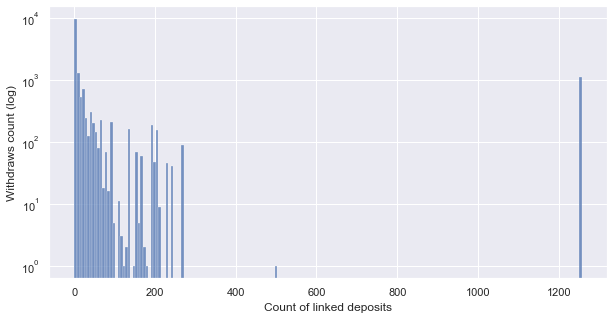

In [16]:
linked_deposits_counts = {}
for key in w2d.keys():
    linked_deposits_counts[key] = len(w2d[key])

sns.set_theme(style="darkgrid")
plt.figure(figsize=(10, 5))
sns.histplot(linked_deposits_counts.values(), bins=200, legend=False)
plt.xlabel("Count of linked deposits")
plt.ylabel("Withdraws count (log)")
plt.yscale("log")

In [17]:
def number_of_linked_withdraw_addresses(w2d_dict: dict) -> int:
    l = []
    for key in w2d_dict.keys():
        l.append(w2addr[key])
    return len(set(l))

In [18]:
w2addr = w2add(withdraw_txs)
d2addr = d2add(deposit_txs)

83782it [00:00, 237225.86it/s]
97365it [00:00, 270610.21it/s]


---
#### How many withdrawal addresses can be linked to deposit addresses?

In [19]:
print(f"Withdrawal addresses that can be linked to deposit addresses: {number_of_linked_withdraw_addresses(w2d)}")

Withdrawal addresses that can be linked to deposit addresses: 4620


#### How many withdrawal transactions can be linked to deposit transactions?

In [20]:
print(f"Withdrawal transactions that can be linked to deposit transactions: {len(w2d)}")

Withdrawal transactions that can be linked to deposit transactions: 15693


In [21]:
# Auxiliary function
# Return all the withdrawals the input address has done.
def get_address_withdraws(address, withdraw_txs):
    return withdraw_txs[withdraw_txs["recipient_address"] == address ].hash

In [22]:
'''
Initialize the address_map, that will follow the next structure
{'withdrawal address': [[withdrawals made],[compromised deposit transactions]], ... }
Definitions:
withdrawals made: The Tcash withdrawals made by the 'withdrawal address'
compromised deposit transactions: The compromised deposit transactions of the 'withdrawals made'.
'''

address_map = {}
for address in unique_withdraw_addresses:
    address_map[address] = [[],[]]

for address in unique_withdraw_addresses:
    deposit = {}
    address_transactions = get_address_withdraws(address, withdraw_txs)
    address_map[address][0] = address_transactions
    for row in address_transactions:
        address_map[address][1] +=  w2d.get(row,[])

In [23]:
'''
Since we want to plot the points (number of withdrawals, number compromised deposit transactions) 
of each withdrawal address,
we need to remove the duplicated compromised deposit transactions and
get the cardinal of each set.
'''

scatter_points = {}
for (address, value) in address_map.items():
    scatter_points[address] = (len(set(value[0])), len(set(value[1])))

In [24]:
'''
So, we end up with the map 
{withdrawal address: (number of withdrawals, number compromised deposit transactions), ...}
'''
scatter_points

{'0x216139dbd2b7f4d2bac9a79f3d19d3ed7ba0335b': (1, 0),
 '0x1f71a39a9c2487207300aab14b7624dd8489caee': (1, 0),
 '0x05e7f8275cee815855ec30e8b1b056797d9c2cd1': (1, 0),
 '0x76250fa32ec7aad373b1acccb43017182b8dbcd8': (1, 0),
 '0x43d19b7139089a63f051ab5b8c89cb425a9d861b': (1, 1),
 '0xdb7a0fa49faf48cf7f7ffdf306221ebff8d1ba4b': (1, 1),
 '0x082de9fc3a53b9ad777650f64883d03a7b06719e': (1, 0),
 '0x8a124ea4f11a9111c8497de15a6f93ed8517e579': (1, 0),
 '0x8390f8cad4f47811919bbfefc45770ee252bdd03': (1, 0),
 '0x7b86e9995eb53ba54e6c0332e55c9e70a6829a94': (9, 9),
 '0xc59cbd025a38554d40c05454f8eec73b9fcee202': (4, 0),
 '0x8a06d14a45a26c51ccde2716af233bbc9c73b661': (1, 0),
 '0xf96f93d8498e3c4d76906e46a50d3603f72cb2c2': (1, 0),
 '0xb194839993c7d2b77adaa8f3af202726dffbafa6': (1, 0),
 '0x87956f4331df3b382bc2ac6e1920dac740cd4aba': (7, 0),
 '0xba91074a864a905371a13a845992b2bddd898ce3': (1, 0),
 '0x95be38e47c4afecf2c44ae46308917401f2a2983': (1, 0),
 '0xe9a43f078908fa851b964e10188918408bb566b9': (1, 0),
 '0x2d50ae

Text(0.5, 1.0, 'Number of withdraws and deposits for each address')

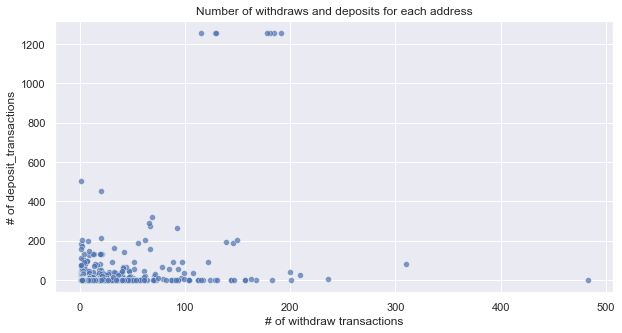

In [25]:
x = [x[0] for x in scatter_points.values()]
y = [x[1] for x in scatter_points.values()]

sns.set_theme(style="darkgrid")
plt.figure(figsize=(10, 5))
sns.scatterplot(x=x,y=y, alpha=0.7)
plt.xlabel("# of withdraw transactions")
plt.ylabel("# of deposit_transactions")
plt.title("Number of withdraws and deposits for each address")

#### Number of compromised deposits

In [26]:
compromised_deposits = set([compromised_deposit for value in address_map.values() for compromised_deposit in value[1]])

In [27]:
len(compromised_deposits)

18998

In [28]:
print(f"Number of compromised deposits: {len(compromised_deposits)}")

Number of compromised deposits: 18998


Average number of compromised deposits per linked withdrawal address

In [29]:
number_of_compromised_deposits =  [value[1] for value in scatter_points.values() if value[1] != 0]

Text(0.5, 1.0, 'Histogram of compromised deposits per linked withdrawal address')

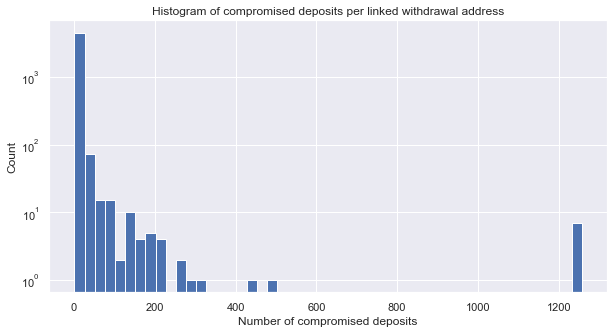

In [30]:
plt.figure(figsize=(10, 5))
plt.hist(number_of_compromised_deposits, bins=50)
plt.yscale("log")
plt.xlabel("Number of compromised deposits")
plt.ylabel("Count")
plt.title("Histogram of compromised deposits per linked withdrawal address")

In [31]:
print(f"Average number of compromised deposits per linked withdrawal address: {sum(number_of_compromised_deposits)/ len(number_of_compromised_deposits)}") 

Average number of compromised deposits per linked withdrawal address: 7.294155844155844


#### Compromised deposit transactions for each TCash pool

In [32]:
def tx_to_pool(txs_df):
    tx_to_pool_dict = {}
    for row in tqdm(txs_df.itertuples(), mininterval=1):
        tx_to_pool_dict[row.hash] = row.tcash_pool
    
    return tx_to_pool_dict

In [33]:
tx_to_pool_dict = tx_to_pool(deposit_txs)
compromised_deposit_hashes = set(list(itertools.chain(*w2d.values())))
number_of_compromised_deposits_by_pool = Counter(list(map(lambda x: tx_to_pool_dict[x], compromised_deposit_hashes)))

97365it [00:00, 271359.86it/s]


In [34]:
pools_to_deposits = dict(deposit_txs.groupby("tcash_pool")["hash"].apply(list))
number_of_uncompromised_deposits_by_pool = {}
for pool in list(pools_to_deposits.keys()):
    number_of_uncompromised_deposits_by_pool[pool] = len(pools_to_deposits[pool]) - number_of_compromised_deposits_by_pool[pool]

In [35]:
compromised_vs_uncompromised_by_pool = {}

for pool in list(number_of_compromised_deposits_by_pool.keys()):
    compromised_vs_uncompromised_by_pool[pool] = (number_of_compromised_deposits_by_pool[pool], number_of_uncompromised_deposits_by_pool[pool])

In [36]:
eth_pools = ["0.1 ETH", "1 ETH", "10 ETH", "100 ETH"]
tkn_pools = [pool for pool in compromised_vs_uncompromised_by_pool.keys() if pool not in eth_pools]
all_pools = eth_pools + tkn_pools

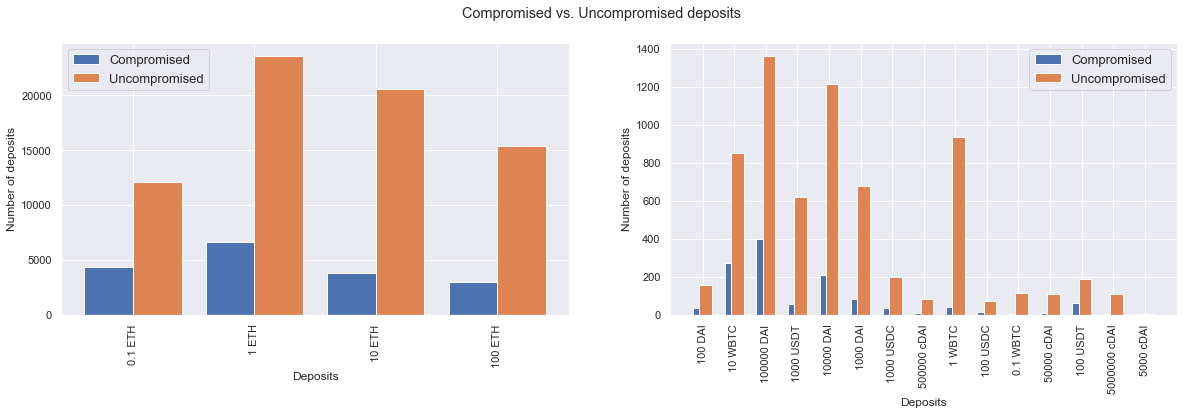

In [37]:
points = [compromised_vs_uncompromised_by_pool[pool] for pool in all_pools]

eth_compromised = [t[0] for t in points[:4]]
eth_uncompromised = [t[1] for t in points[:4]]
eth_x_axis = np.arange(len(eth_pools))

tkn_compromised = [t[0] for t in points[4:]]
tkn_uncompromised = [t[1] for t in points[4:]]
tkn_x_axis = np.arange(len(tkn_pools))

sns.set_theme(style="darkgrid")
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(20, 5))
ax1.bar(eth_x_axis - 0.2, eth_compromised, 0.4, label = "Compromised")
ax1.bar(eth_x_axis + 0.2, eth_uncompromised, 0.4, label = "Uncompromised")
ax1.set_xticks(eth_x_axis)
ax1.set_xticklabels(eth_pools, rotation="vertical")
ax1.set_xlabel("Deposits")
ax1.set_ylabel("Number of deposits")
ax1.legend(fontsize=13)

ax2.bar(tkn_x_axis - 0.1, tkn_compromised, 0.4, label = "Compromised")
ax2.bar(tkn_x_axis + 0.1, tkn_uncompromised, 0.4, label = "Uncompromised")
ax2.set_xticks(tkn_x_axis)
ax2.set_xticklabels(tkn_pools, rotation="vertical")
ax2.set_xlabel("Deposits")
ax2.set_ylabel("Number of deposits")
ax2.legend(fontsize=13)
fig.suptitle("Compromised vs. Uncompromised deposits")

plt.show()

In [38]:
rate_compromised_vs_uncompromised_by_pool = {}
for pool in compromised_vs_uncompromised_by_pool.keys():
    n_compromised = compromised_vs_uncompromised_by_pool[pool][0]
    n_uncompromised = compromised_vs_uncompromised_by_pool[pool][1]
    total_deposits = n_compromised + n_uncompromised
    
    rate_compromised_vs_uncompromised_by_pool[pool] = (n_compromised/total_deposits * 100, n_uncompromised/total_deposits * 100)

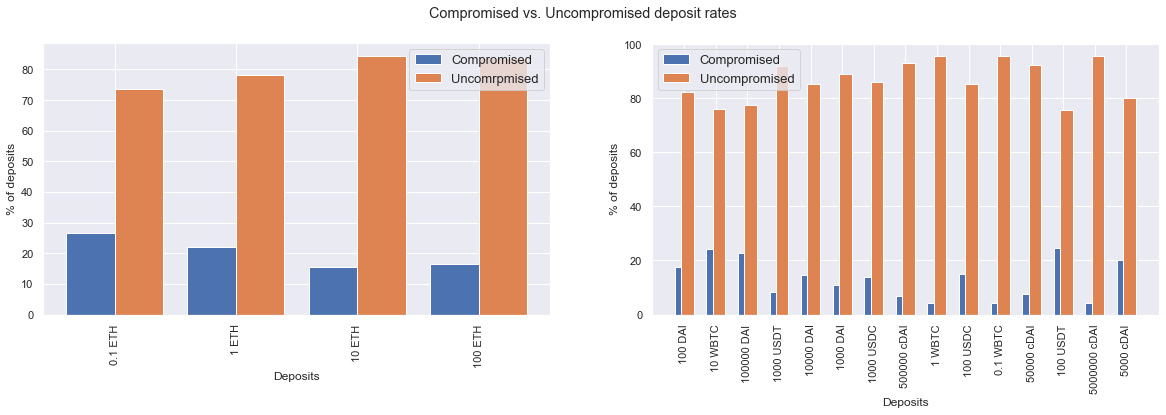

In [39]:
rate_points = [rate_compromised_vs_uncompromised_by_pool[pool] for pool in all_pools]

eth_compromised = [t[0] for t in rate_points[:4]]
eth_uncompromised = [t[1] for t in rate_points[:4]]
eth_x_axis = np.arange(len(eth_pools))

tkn_compromised = [t[0] for t in rate_points[4:]]
tkn_uncompromised = [t[1] for t in rate_points[4:]]
tkn_x_axis = np.arange(len(tkn_pools))


fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(20, 5))
ax1.bar(eth_x_axis - 0.2, eth_compromised, 0.4, label = "Compromised")
ax1.bar(eth_x_axis + 0.2, eth_uncompromised, 0.4, label = "Uncomrpmised")
ax1.set_xticks(eth_x_axis)
ax1.set_xticklabels(eth_pools, rotation="vertical")
ax1.set_xlabel("Deposits")
ax1.set_ylabel("% of deposits")
ax1.legend(fontsize=13)

ax2.bar(tkn_x_axis - 0.1, tkn_compromised, 0.4, label = "Compromised")
ax2.bar(tkn_x_axis + 0.1, tkn_uncompromised, 0.4, label = "Uncompromised")
ax2.set_xticks(tkn_x_axis)
ax2.set_xticklabels(tkn_pools, rotation="vertical")
ax2.set_xlabel("Deposits")
ax2.set_ylabel("% of deposits")
ax2.legend(fontsize=13)
fig.suptitle("Compromised vs. Uncompromised deposit rates")

plt.show()

In [40]:
txs = np.empty((len(address_and_withdraw_df)), dtype=set)
for i, row in enumerate(address_and_withdraw_df.itertuples()):
    txs[i] = frozenset([row.from_address, row.to_address])

txs = list(filter(lambda x: len(x) == 2, txs))
recurrent_interactions = list(Counter(txs).values())

Text(0.5, 1.0, 'Histogram of transactions between heuristically linked deposit and withdraw addresses outisde TCash')

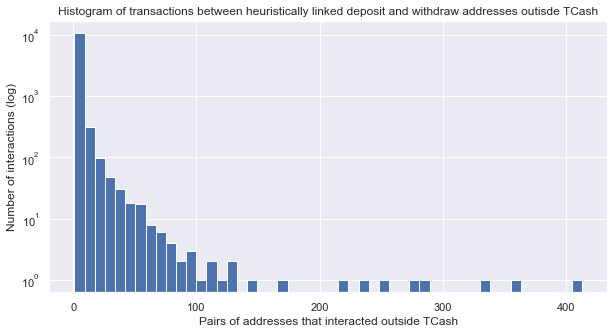

In [41]:
plt.figure(figsize=(10, 5))
plt.hist(recurrent_interactions, bins=50)
plt.yscale("log")
plt.xlabel("Pairs of addresses that interacted outside TCash")
plt.ylabel("Number of interactions (log)")
plt.title("Histogram of transactions between heuristically linked deposit and withdraw addresses outisde TCash")